# Intelligenza Artificiale tra Geometria e Fisica

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score
from tensorflow.keras.datasets import mnist
from utils import utils

import numpy as np
import pandas as pd
import seaborn as sns

# set memory growth
utils.set_memory_growth()

# set random seed
rs = np.random.RandomState(0)

## Machine Learning

In [2]:
X, y = load_iris(return_X_y=True, as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, shuffle=True, random_state=rs)

In [3]:
X_train.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
85,6.0,3.4,4.5,1.6
30,4.8,3.1,1.6,0.2
101,5.8,2.7,5.1,1.9
94,5.6,2.7,4.2,1.3
64,5.6,2.9,3.6,1.3


In [4]:
names = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
y_train_dummy = pd.get_dummies(y_train.replace(names)).values
y_test_dummy  = pd.get_dummies(y_test.replace(names)).values
y_train.replace(names).head(5)

85     versicolor
30         setosa
101     virginica
94     versicolor
64     versicolor
Name: target, dtype: object

### Approccio "Unsupervised"

#### Clustering

In [5]:
kmeans = KMeans(n_clusters=3, random_state=rs)
t_labs = pd.Series(kmeans.fit_predict(X_train), name='target').replace(names)

#### Visualizzazione con PCA

In [6]:
pca  = PCA(n_components=2, random_state=rs)
t_cp = pd.DataFrame(pca.fit_transform(X_train), columns=['pc_1', 'pc_2'])
d_cp = pd.DataFrame(pca.transform(X_test), columns=['pc_1', 'pc_2'])

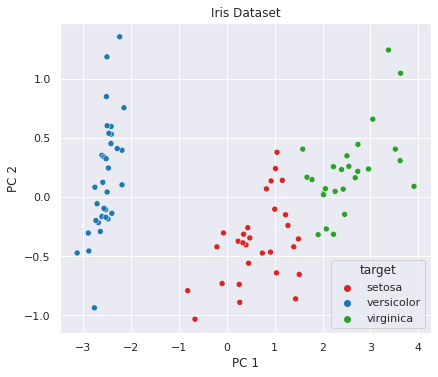

In [7]:
fig, ax = utils.subplots()

sns.scatterplot(data=t_cp,
                x='pc_1',
                y='pc_2',
                hue=t_labs,
                palette=['tab:red', 'tab:blue', 'tab:green'],
                ax=ax
               )

ax.set(xlabel='PC 1', ylabel='PC 2', title='Iris Dataset');

#### Visualizzazione con TSNE

In [8]:
tsne  = TSNE(n_components=2, random_state=rs, n_jobs=-1)
t_rep = pd.DataFrame(tsne.fit_transform(X_train), columns=['tsne_1', 'tsne_2'])
d_rep = pd.DataFrame(tsne.fit_transform(X_test), columns=['tsne_1', 'tsne_2'])

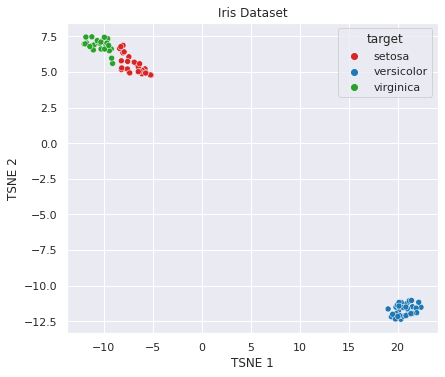

In [9]:
fig, ax = utils.subplots()

sns.scatterplot(data=t_rep,
                x='tsne_1',
                y='tsne_2',
                hue=t_labs,
                palette=['tab:red', 'tab:blue', 'tab:green'],
                ax=ax
               )

ax.set(xlabel='TSNE 1', ylabel='TSNE 2', title='Iris Dataset');

### Approccio "Supervised"

#### Curva logistica

In [10]:
lr = LogisticRegression(C=1.0e5, n_jobs=-1)
lr = lr.fit(X_train, y_train)

In [11]:
y_pred = pd.Series(lr.predict(X_test), name='prediction')
y_prob = lr.predict_proba(X_test)
ident  = pd.Series(y_pred.values == y_test.values, name='test').replace({True: 'ok', False: 'wrong'})

#### Visualizzazione con PCA

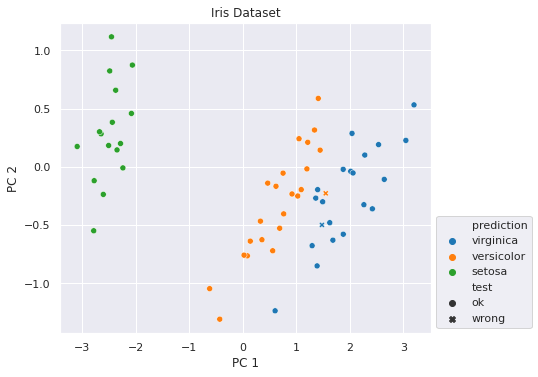

In [12]:
fig, ax = utils.subplots()

sns.scatterplot(data=d_cp,
                x='pc_1',
                y='pc_2',
                hue=y_pred.replace(names),
                style=ident,
                ax=ax
               )

ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.0))
ax.set(xlabel='PC 1', ylabel='PC 2', title='Iris Dataset');

#### Visualizzazione con TSNE

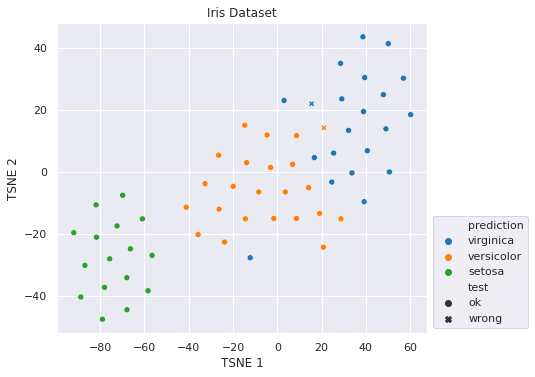

In [13]:
fig, ax = utils.subplots()

sns.scatterplot(data=d_rep,
                x='tsne_1',
                y='tsne_2',
                hue=y_pred.replace(names),
                style=ident,
                ax=ax
               )

ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.0))
ax.set(xlabel='TSNE 1', ylabel='TSNE 2', title='Iris Dataset');

#### Efficacia della classificazione

In [14]:
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {100 * acc:.1f}%')

pre = precision_score(y_test, y_pred, average='micro')
print(f'Precision: {100 * pre:.1f}%')

rec = recall_score(y_test, y_pred, average='micro')
print(f'Recall: {100 * pre:.2f}%')

Accuracy: 96.7%
Precision: 96.7%
Recall: 96.67%


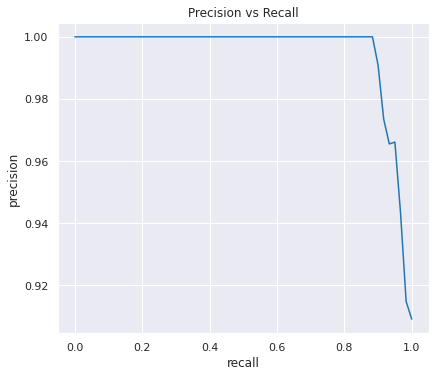

In [15]:
p, r, _ = precision_recall_curve(y_test_dummy.ravel(), y_prob.ravel())

fig, ax = utils.subplots()

sns.lineplot(x=r,
             y=p,
             ci=None,
             ax=ax
            )

ax.set(xlabel='recall', ylabel='precision', title='Precision vs Recall');

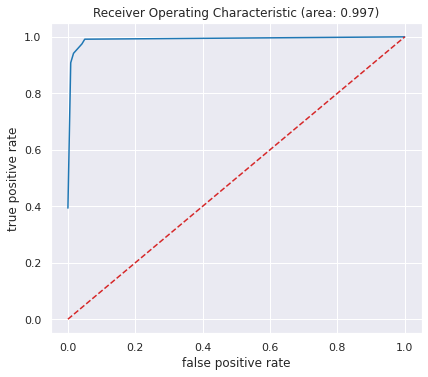

In [16]:
fpr, tpr, _ = roc_curve(y_test_dummy.ravel(), y_prob.ravel())

fig, ax = utils.subplots()

sns.lineplot(x=fpr,
             y=tpr,
             ci=None,
             ax=ax
            )

sns.lineplot(x=np.linspace(0.0, 1.0, num=100),
             y=np.linspace(0.0, 1.0, num=100),
             color='tab:red',
             linestyle='--',
             ax=ax
            )

score = roc_auc_score(y_test_dummy.ravel(), y_prob.ravel())
ax.set(xlabel='false positive rate',
       ylabel='true positive rate',
       title=f'Receiver Operating Characteristic (area: {score:.3f})'
      );

### Unsupervised + Supervised

#### Curva logistica + TSNE

In [24]:
lr = LogisticRegression(C=1.0e5, n_jobs=-1)
lr = lr.fit(t_rep, y_train)

In [25]:
y_pred = pd.Series(lr.predict(d_rep), name='prediction')
y_prob = lr.predict_proba(d_rep)
ident  = pd.Series(y_pred.values == y_test.values, name='test').replace({True: 'ok', False: 'wrong'})

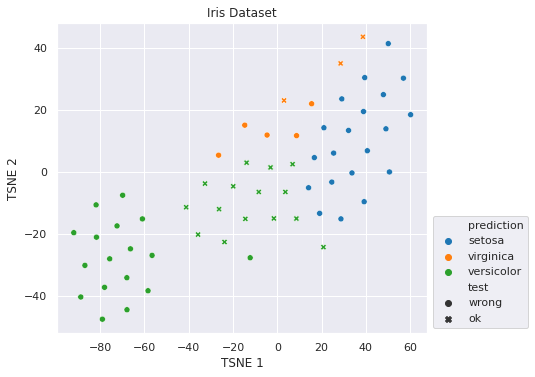

In [26]:
fig, ax = utils.subplots()

sns.scatterplot(data=d_rep,
                x='tsne_1',
                y='tsne_2',
                hue=y_pred.replace(names),
                style=ident,
                ax=ax
               )

ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.0))
ax.set(xlabel='TSNE 1', ylabel='TSNE 2', title='Iris Dataset');

In [27]:
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {100 * acc:.1f}%')

pre = precision_score(y_test, y_pred, average='micro')
print(f'Precision: {100 * pre:.1f}%')

rec = recall_score(y_test, y_pred, average='micro')
print(f'Recall: {100 * pre:.2f}%')

Accuracy: 30.0%
Precision: 30.0%
Recall: 30.00%


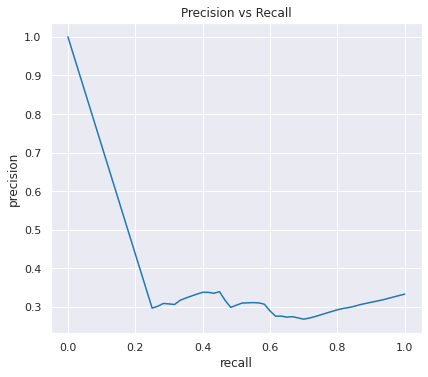

In [28]:
p, r, _ = precision_recall_curve(y_test_dummy.ravel(), y_prob.ravel())

fig, ax = utils.subplots()

sns.lineplot(x=r,
             y=p,
             ci=None,
             ax=ax
            )

ax.set(xlabel='recall', ylabel='precision', title='Precision vs Recall');

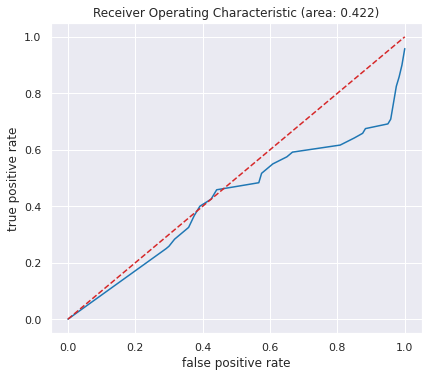

In [29]:
fpr, tpr, _ = roc_curve(y_test_dummy.ravel(), y_prob.ravel())

fig, ax = utils.subplots()

sns.lineplot(x=fpr,
             y=tpr,
             ci=None,
             ax=ax
            )

sns.lineplot(x=np.linspace(0.0, 1.0, num=100),
             y=np.linspace(0.0, 1.0, num=100),
             color='tab:red',
             linestyle='--',
             ax=ax
            )

score = roc_auc_score(y_test_dummy.ravel(), y_prob.ravel())
ax.set(xlabel='false positive rate',
       ylabel='true positive rate',
       title=f'Receiver Operating Characteristic (area: {score:.3f})'
      );

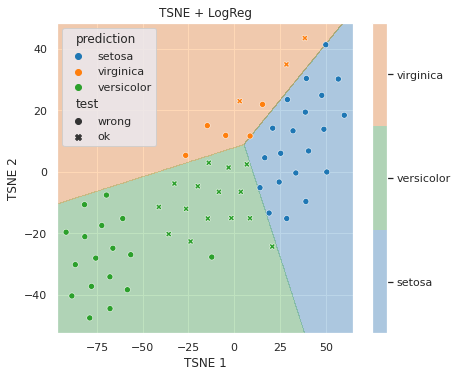

In [30]:
x = np.arange(d_rep['tsne_1'].min() - 5.0, d_rep['tsne_1'].max() + 5.0, 0.1)
y = np.arange(d_rep['tsne_2'].min() - 5.0, d_rep['tsne_2'].max() + 5.0, 0.1)
x_grid, y_grid = np.meshgrid(x, y)
grid = np.c_[x_grid.ravel(), y_grid.ravel()]
bnd  = lr.predict(grid).reshape(x_grid.shape)

fig, ax = utils.subplots()

c = ax.contourf(x_grid,
                y_grid,
                bnd,
                levels=[-1, 0, 1, 2],
                colors=[sns.color_palette(n_colors=3)[i] for i in [0, 2, 1]],
                alpha=0.3
               )

cbar = fig.colorbar(c, ticks=[-0.5, 0.5, 1.5], ax=ax)
cbar.set_ticklabels(names)

sns.scatterplot(data=d_rep,
                x='tsne_1',
                y='tsne_2',
                hue=y_pred.replace(names),
                style=ident,
                ax=ax
               )

ax.set(xlabel='TSNE 1', ylabel='TSNE 2', title='TSNE + LogReg');

#### Curva logistica + PCA

In [17]:
lr = LogisticRegression(C=1.0e5, n_jobs=-1)
lr = lr.fit(t_cp, y_train)

In [18]:
y_pred = pd.Series(lr.predict(d_cp), name='prediction')
y_prob = lr.predict_proba(d_cp)
ident  = pd.Series(y_pred.values == y_test.values, name='test').replace({True: 'ok', False: 'wrong'})

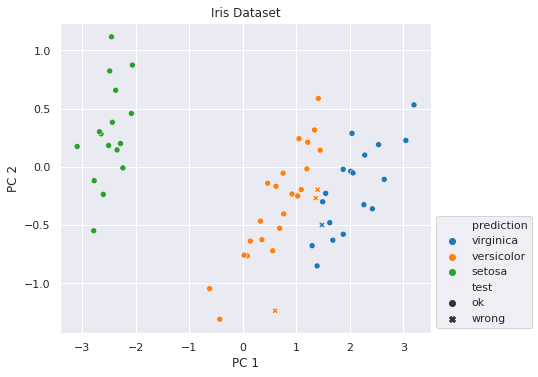

In [19]:
fig, ax = utils.subplots()

sns.scatterplot(data=d_cp,
                x='pc_1',
                y='pc_2',
                hue=y_pred.replace(names),
                style=ident,
                ax=ax
               )

ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.0))
ax.set(xlabel='PC 1', ylabel='PC 2', title='Iris Dataset');

In [20]:
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {100 * acc:.1f}%')

pre = precision_score(y_test, y_pred, average='micro')
print(f'Precision: {100 * pre:.1f}%')

rec = recall_score(y_test, y_pred, average='micro')
print(f'Recall: {100 * pre:.2f}%')

Accuracy: 93.3%
Precision: 93.3%
Recall: 93.33%


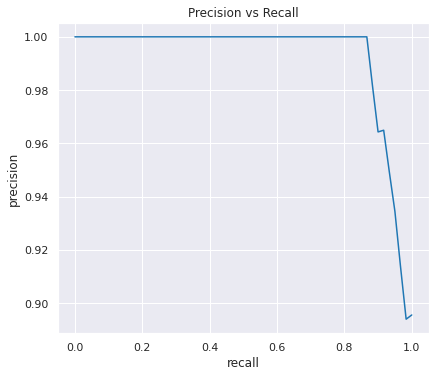

In [21]:
p, r, _ = precision_recall_curve(y_test_dummy.ravel(), y_prob.ravel())

fig, ax = utils.subplots()

sns.lineplot(x=r,
             y=p,
             ci=None,
             ax=ax
            )

ax.set(xlabel='recall', ylabel='precision', title='Precision vs Recall');

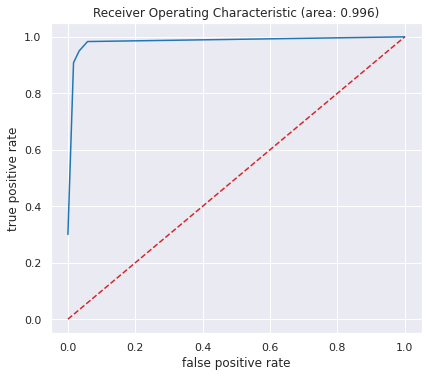

In [22]:
fpr, tpr, _ = roc_curve(y_test_dummy.ravel(), y_prob.ravel())

fig, ax = utils.subplots()

sns.lineplot(x=fpr,
             y=tpr,
             ci=None,
             ax=ax
            )

sns.lineplot(x=np.linspace(0.0, 1.0, num=100),
             y=np.linspace(0.0, 1.0, num=100),
             color='tab:red',
             linestyle='--',
             ax=ax
            )

score = roc_auc_score(y_test_dummy.ravel(), y_prob.ravel())
ax.set(xlabel='false positive rate',
       ylabel='true positive rate',
       title=f'Receiver Operating Characteristic (area: {score:.3f})'
      );

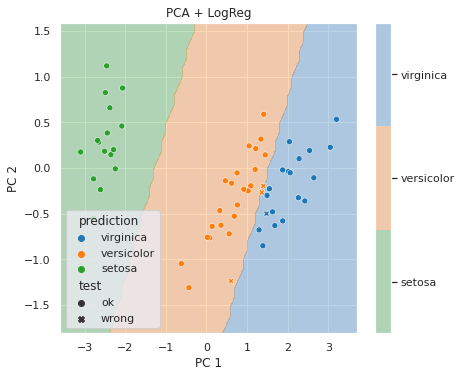

In [23]:
x = np.arange(d_cp['pc_1'].min() - 0.5, d_cp['pc_1'].max() + 0.5, 0.1)
y = np.arange(d_cp['pc_2'].min() - 0.5, d_cp['pc_2'].max() + 0.5, 0.1)
x_grid, y_grid = np.meshgrid(x, y)
grid = np.c_[x_grid.ravel(), y_grid.ravel()]
bnd  = lr.predict(grid).reshape(x_grid.shape)

fig, ax = utils.subplots()

c = ax.contourf(x_grid,
                y_grid,
                bnd,
                levels=[-1, 0, 1, 2],
                colors=sns.color_palette(n_colors=3)[::-1],
                alpha=0.3
               )

cbar = fig.colorbar(c, ticks=[-0.5, 0.5, 1.5], ax=ax)
cbar.set_ticklabels(names)

sns.scatterplot(data=d_cp,
                x='pc_1',
                y='pc_2',
                hue=y_pred.replace(names),
                style=ident,
                ax=ax
               )

ax.set(xlabel='PC 1', ylabel='PC 2', title='PCA + LogReg');

## Intelligenza Artificiale?

In [31]:
#(X_train, y_train), (X_test, y_test) = mnist.load_data()

### Multi-Layered Perceptron

### Convolutional Neural Network

### Autoencoder

### 